# Imports and Setting up Plotting

In [1]:
from datetime import date, timedelta
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rcParams = {'figure.max_open_warning': 0,
            'figure.figsize': (15, 8),
            'axes.grid': True}

plt.rcParams.update(rcParams)
plt.style.use('bmh')

pd.options.display.max_rows = 50

# Loading Data

In [2]:
# Reading CSV files and Loading the data
#filepath = r'c:\src\interview_project_data\*.csv'

filepath = r'C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\*.csv'
csv_files = glob.glob(filepath)

data = {}

for csv_file in csv_files:
    print('Loading ', csv_file)
    data_key = csv_file.rsplit('\\', 1)[-1].split('.')[0]    
    df = pd.read_csv(csv_file)
    df.set_index('dates', inplace=True)
    df.index = pd.to_datetime(df.index)
    data[data_key] = df
    
asset_prices = data['asset_prices']

# Firstly Grab the data by country
countries = ['US', 'CA']
data_labels = ['Unemployment', 'IndustrialProduction', 'GDP', 'HomeSales']

economic_data = {}

for country in countries:
    tmp_data = {}

    for label in data_labels:
        tmp_data[f'{label}'] = data[f'{country}_{label}']

    economic_data[f'{country}'] = tmp_data

Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\asset_prices.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\CA_GDP.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\CA_HomeSales.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\CA_IndustrialProduction.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\CA_Unemployment.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\US_GDP.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\US_HomeSales.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\US_IndustrialProduction.csv
Loading  C:\Users\johne\Downloads\FW_ Investment Associate Second Round Project\US_Unemployment.csv


## Examining Data

In [3]:
asset_prices

,ES1 Index,PT1 Index,CADUSD Curncy,DXY Curncy
dates,,,,
1980-01-01,NaN,NaN,0.8559,85.820
1980-01-02,NaN,NaN,0.8578,85.320
1980-01-03,NaN,NaN,0.8545,85.260
1980-01-04,NaN,NaN,0.8557,85.230
1980-01-07,NaN,NaN,0.8551,84.790
...,...,...,...,...
2023-01-20,3988.50,1237.2,0.7474,102.012
2023-01-23,4036.50,1244.9,0.7481,102.138
2023-01-24,4032.75,1244.1,0.7480,101.918


In [4]:
economic_data

{'US': {'Unemployment':             actual_value  expected_value  number_of_forecaster
  dates                                                         
  1997-02-07           5.4             5.3                   0.0
  1997-03-07           5.3             5.3                   0.0
  1997-04-04           5.2             5.2                   0.0
  1997-05-02           4.9             5.2                   0.0
  1997-06-06           4.8             5.0                   0.0
  ...                  ...             ...                   ...
  2022-05-06           3.6             3.5                  76.0
  2022-06-03           3.6             3.5                  69.0
  2022-07-08           3.6             3.6                  74.0
  2022-08-05           3.5             3.6                  71.0
  2022-09-02           3.7             3.5                  71.0
  
  [307 rows x 3 columns],
  'IndustrialProduction':             actual_value  expected_value  number_of_forecaster
  dates        

# Building An Indicator

In this example, we assume that the growth rate of GDP is a good indication of the growth of a country's economy. For illustrative and simplicity reasons, we will focus on only this data. With this assumption, again for simplicity, we propose our indicator as just the actual value of GDP growth rate.

In [5]:
us_gdp = economic_data['US']['GDP']['actual_value']  # US GDP growth rate
ca_gdp = economic_data['CA']['GDP']['actual_value']  # Canada GDP growth rate

gdp = pd.concat([us_gdp, ca_gdp], axis=1, sort=True, keys=['US', 'CA'])

In [6]:
# our economic indicator is just the GDP growth rate
ca_indicator = ca_gdp
us_indicator = us_gdp

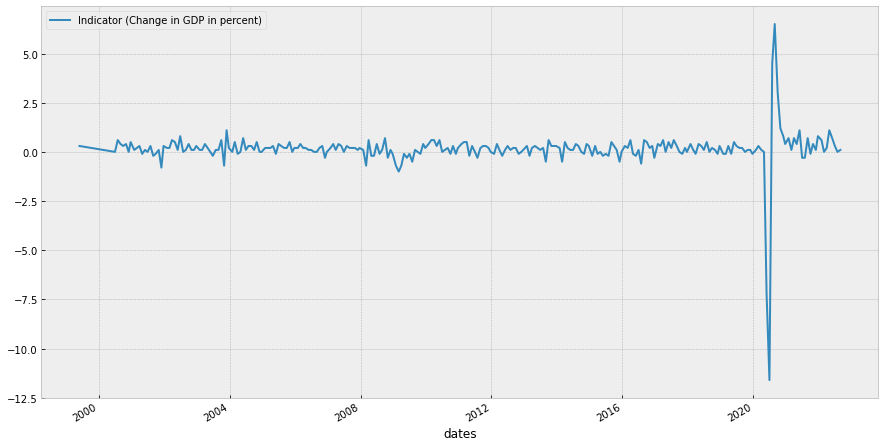

In [7]:
ca_indicator.plot(label='Indicator (Change in GDP in percent)')
plt.legend()

# Building a Trading Signal Using the Indicator

Using the indicator that we have created, we then try to create a trading signal.

We start by thinking how we can trade this strategy.

The most simplistic use of the indicator to trade would be using the indicator as the trading signal without any transformation. In our example, that would mean buy (go long) when the change in GDP is positive, and sell (go short) when the change in GDP is negative. This approach is shown in basic_signal() below.

We encourage you to try some new signals. As an example of how a signal might look like, you can look at the momentum trading signal in the Software Engineering project (Project 1).

In [8]:
def basic_signal(ts):
    # ts is a vector
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])
    signal[ts > 0] = 1
    signal[ts < 0] = -1
    
    return signal

In [9]:
ca_sgnl = basic_signal(ca_gdp)
us_sgnl = basic_signal(us_gdp)
ca_sgnl

,signal
dates,
1999-05-31,1.0
2000-06-30,0.0
2000-07-31,1.0
2000-08-31,1.0
2000-09-29,1.0
...,...
2022-04-29,1.0
2022-05-31,1.0
2022-06-30,1.0


## Show Performance of the Trading Signal

### Choose the assets you want to trade

In [10]:
# In this case, we are postulating that when the change in GDP is positive,
# both the country's stock market and the country's currency will rise.
ca_assets = ['PT1 Index', 'CADUSD Curncy']
us_assets = ['ES1 Index', 'DXY Curncy']

### Calculate PnL

In [11]:
def calculate_pnl(ret, pos):
    # function to calculate profit and loss
    # we trade at the end of the period, and take profit & loss on the market move next period on our position
    # that's why we are shifting positon vector by one
    return ret.multiply(pos.shift(), axis=0).dropna()

In [12]:
# build the return series for each of the series
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()

# Resample the Signal into daily signal
ca_daily_pos = ca_sgnl.resample('D').ffill()
us_daily_pos = us_sgnl.resample('D').ffill()

In [13]:
us_pnl = calculate_pnl(us_returns, us_daily_pos['signal'])
ca_pnl = calculate_pnl(ca_returns, us_daily_pos['signal'])

<AxesSubplot:title={'center':'Cumulative Trading Profit'}, xlabel='dates'>

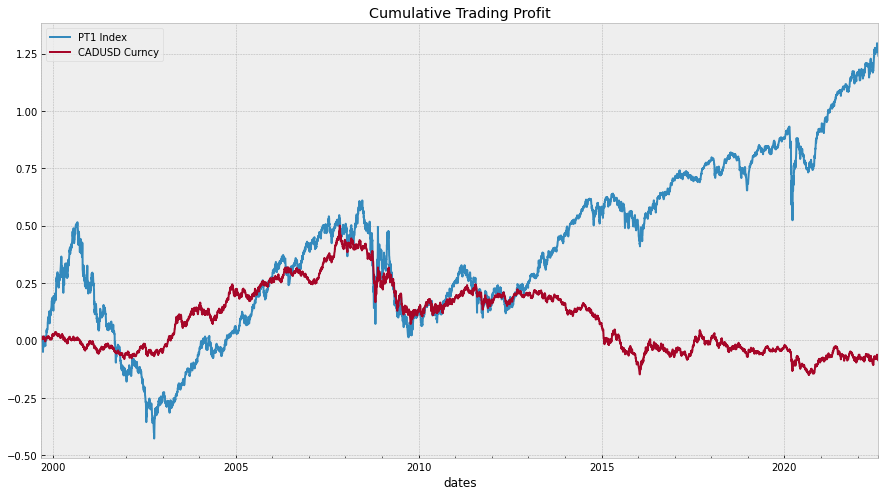

In [14]:
ca_pnl.cumsum().plot(title='Cumulative Trading Profit')

<AxesSubplot:title={'center':'Cumulative Trading Profit'}, xlabel='dates'>

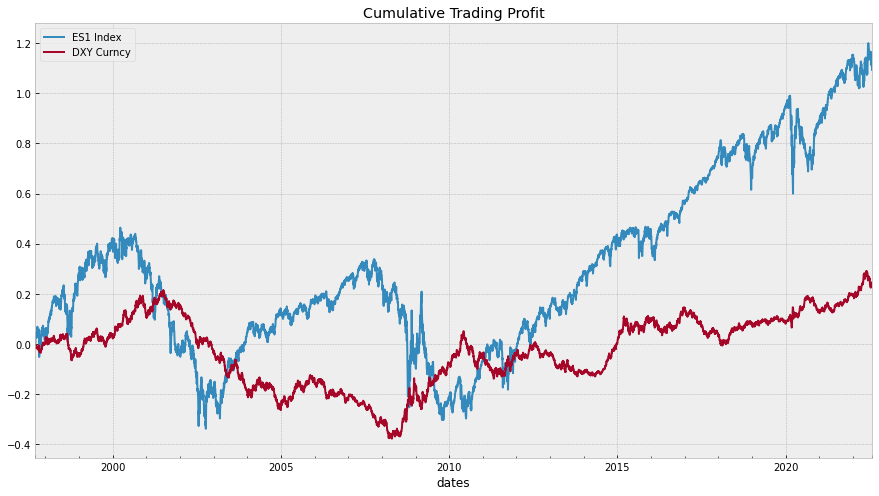

In [15]:
us_pnl.cumsum().plot(title='Cumulative Trading Profit')

## Some thoughts on the performance of the trading signal

Please examine the results of your trading signal and provide some commentary on the performance. 

If it performs well. Why? If it doesn't, why not? How can you make it better? 

What would be the next steps, if on the job, you are asked to further explore this investigation?

# John Eriksson's work below

I decided to start looking at the relationship between the expected and actual values, and to see what insights I could get from looking at divergences in expectations in the economic data.

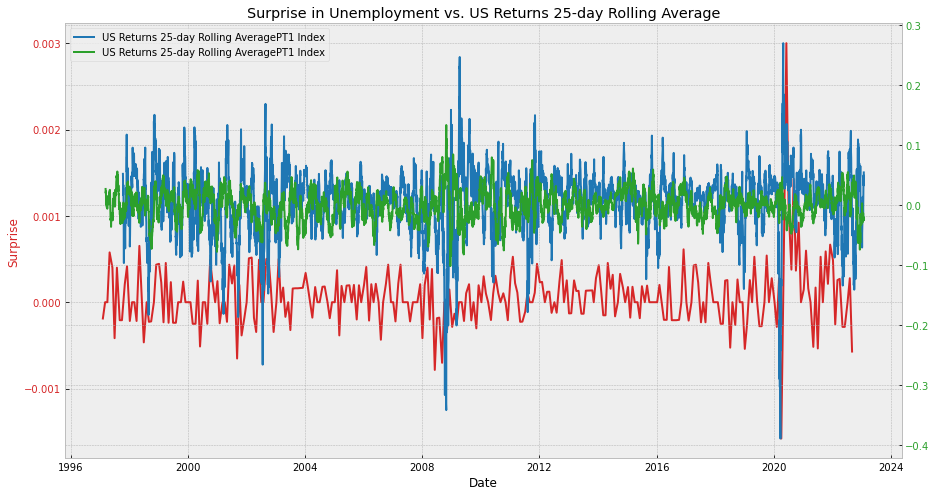

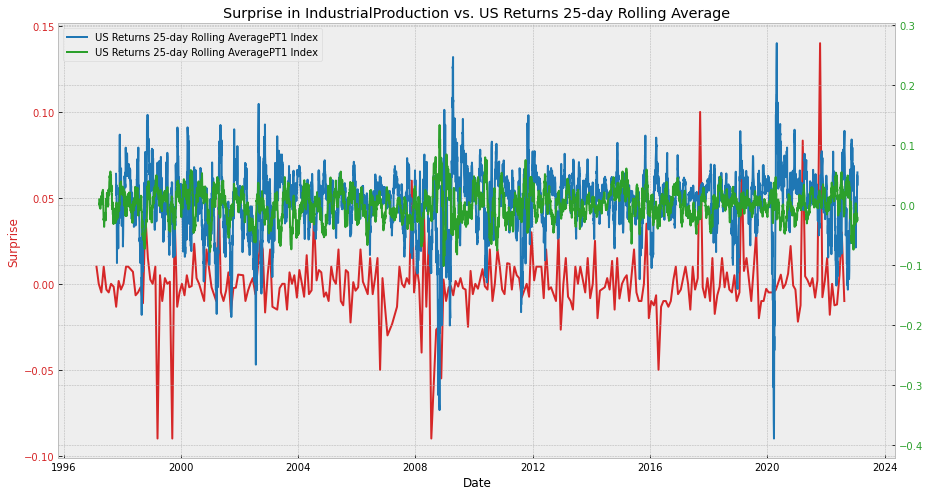

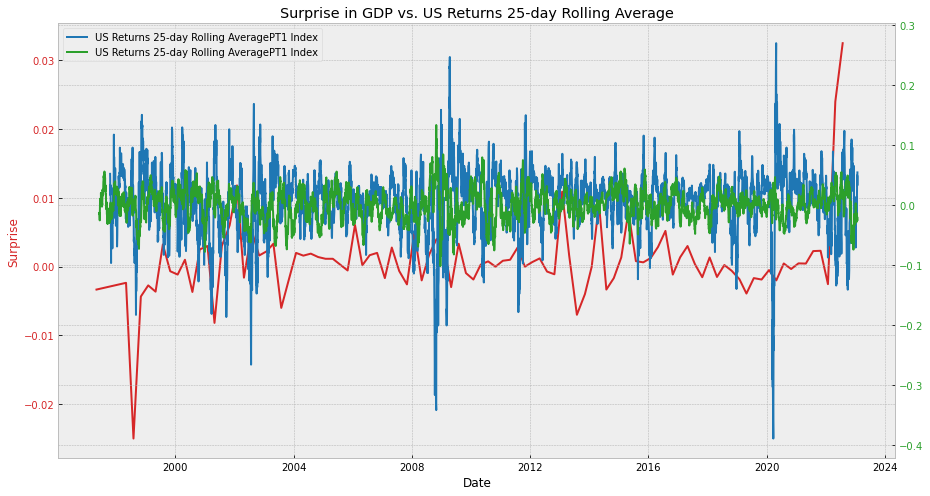

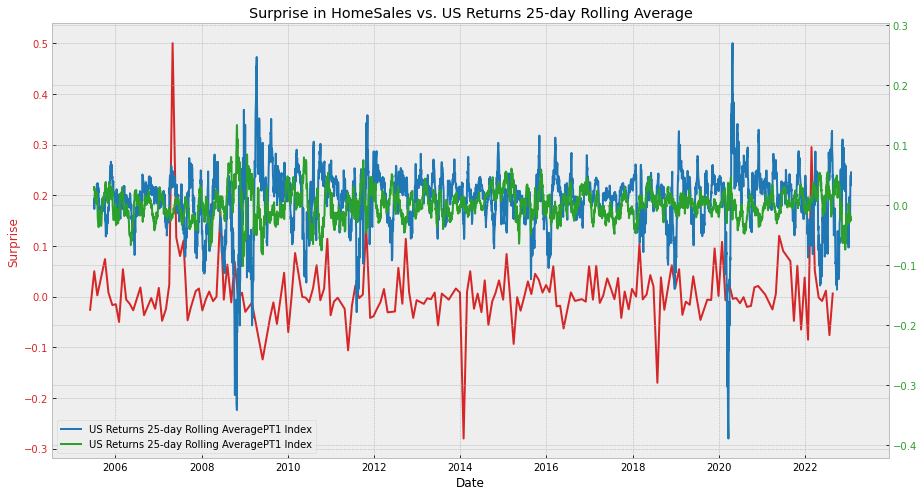

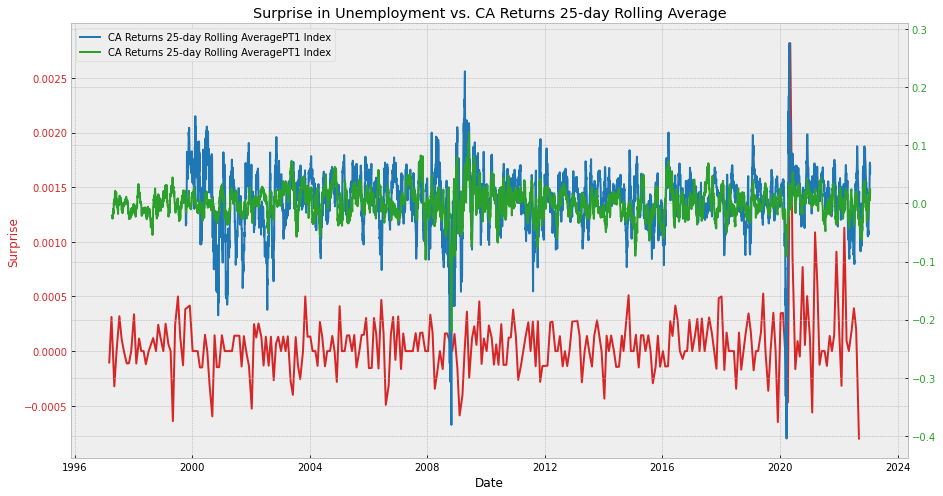

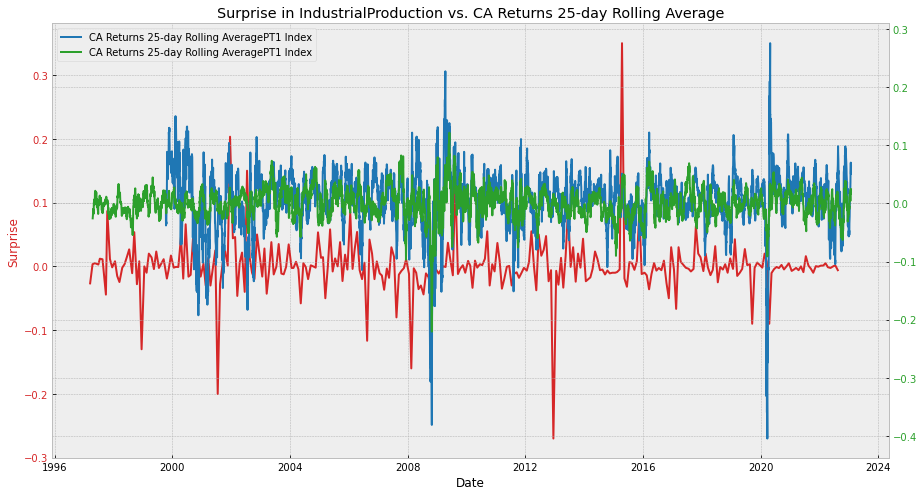

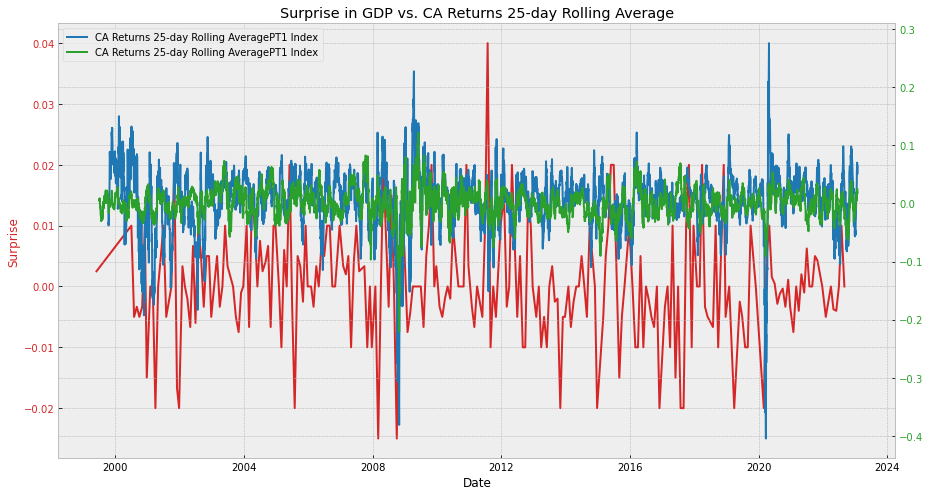

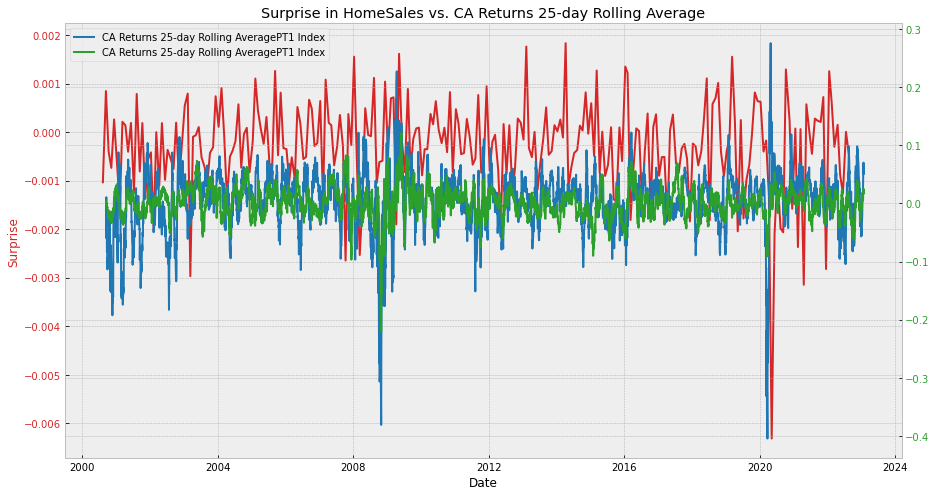

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_surprise(economic_data, region, parameter,ca_returns,us_returns):
    df = economic_data[region][parameter]
    df = df[df['expected_value'] != 0]
    surprise = ((df['expected_value'] - df['actual_value']) / df['expected_value'])
    surprise.fillna(0, inplace=True)
    surprise.replace(np.inf, 0, inplace=True)
    surprise /= 100
    
    rolling_window = 25  # Approximate number of weekdays in a month

    # Ensure correct referencing for rolling averages
    if region == 'CA':
        rolling_average = ca_returns.loc[ca_returns.index >= min(surprise.index)].rolling(window=rolling_window).sum()
        rolling_label = 'CA Returns 25-day Rolling Average'
    else:
        rolling_average = us_returns.loc[us_returns.index >= min(surprise.index)].rolling(window=rolling_window).sum()
        rolling_label = 'US Returns 25-day Rolling Average'
    fig, ax1 = plt.subplots()

   

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Surprise', color=color)
    ax1.plot(surprise.index, surprise.values, color=color, label=f'{parameter} %Surprise')  # Use .values for clarity
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.plot(rolling_average[rolling_average.columns[0]].index, rolling_average[rolling_average.columns[0]].values, color=color, label=rolling_label+ "PT1 Index")  # Use .values
    ax2.tick_params(axis='y', labelcolor=color)
    color = 'tab:green'
    ax2.plot(rolling_average[rolling_average.columns[1]].index, rolling_average[rolling_average.columns[1]].values, color=color, label=rolling_label+ "PT1 Index")  # Use .values
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Surprise in {parameter} vs. {rolling_label}')
    plt.legend()
    plt.show()




for indicator in economic_data["US"]:
    plot_surprise(economic_data,'US',indicator,ca_returns,us_returns)
for indicator in economic_data["CA"]:
    plot_surprise(economic_data,"CA",indicator,ca_returns,us_returns)


These results confirmed that generally, there is a strong correlation between these indicators and asset returns. From here, I wanted to see if the surprise could be a leading indicator for asset performance. 

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def asset_correlation_with_lag(economic_data, region, parameter, ca_returns, us_returns):
    df = economic_data[region][parameter]
    df = df[df['expected_value'] != 0]
    surprise = ((df['actual_value'] - df['expected_value']) / df['expected_value'])
    surprise.fillna(0, inplace=True)
    surprise.replace(np.inf, 0, inplace=True)
    surprise /= 100  # Adjusted division for percentage

    # Choose returns based on region
    if region == 'CA':
        rolling_average = ca_returns.loc[ca_returns.index >= min(surprise.index)].rolling(window=25).mean()
        rolling_label = 'CA Returns 25-day Rolling Mean'
    else:
        rolling_average = us_returns.loc[us_returns.index >= min(surprise.index)].rolling(window=25).mean()
        rolling_label = 'US Returns 25-day Rolling Mean'

    # Align indices for correlation calculation
    rolling_average = rolling_average[rolling_average.index.isin(surprise.index)]

    lag_days = -25  
    lagged_surprise = surprise.shift(lag_days).fillna(0)  
    lagged_corr = lagged_surprise.corr(rolling_average.iloc[:, 0])
    print(f"Lagged surprise correlation with {rolling_label}: {lagged_corr}")


for indicator in economic_data["US"]:
    asset_correlation_with_lag(economic_data, 'US', indicator, ca_returns, us_returns)


for indicator in economic_data["CA"]:
    asset_correlation_with_lag(economic_data, 'CA', indicator, ca_returns, us_returns)

Lagged surprise correlation with US Returns 25-day Rolling Mean: 0.03314076851771844
Lagged surprise correlation with US Returns 25-day Rolling Mean: -0.0070122371681911955
Lagged surprise correlation with US Returns 25-day Rolling Mean: 0.13039881564360287
Lagged surprise correlation with US Returns 25-day Rolling Mean: -0.165667361293976
Lagged surprise correlation with CA Returns 25-day Rolling Mean: -0.004040342932056651
Lagged surprise correlation with CA Returns 25-day Rolling Mean: -0.02092259688588408
Lagged surprise correlation with CA Returns 25-day Rolling Mean: -0.028235668866429302
Lagged surprise correlation with CA Returns 25-day Rolling Mean: -0.004363471644946741


The above didn't tell me much, so I decided to take a different approach. I wanted to see if smoothing the data derived new insights. 


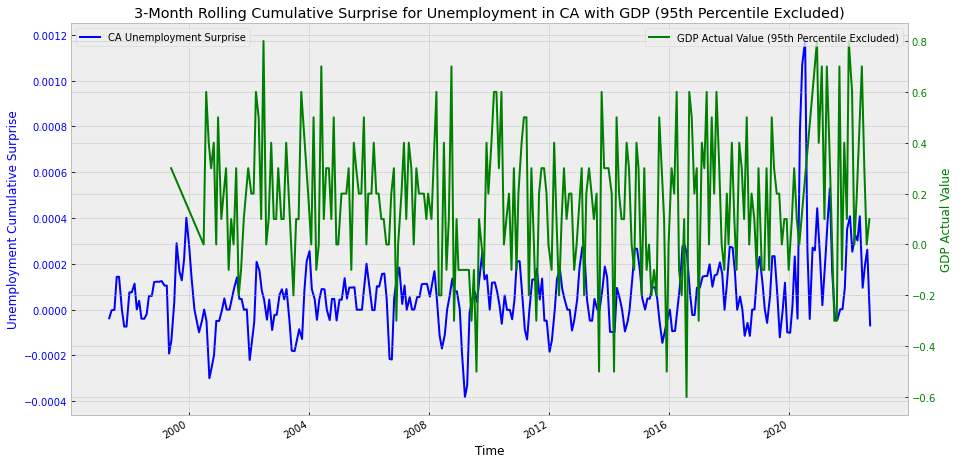

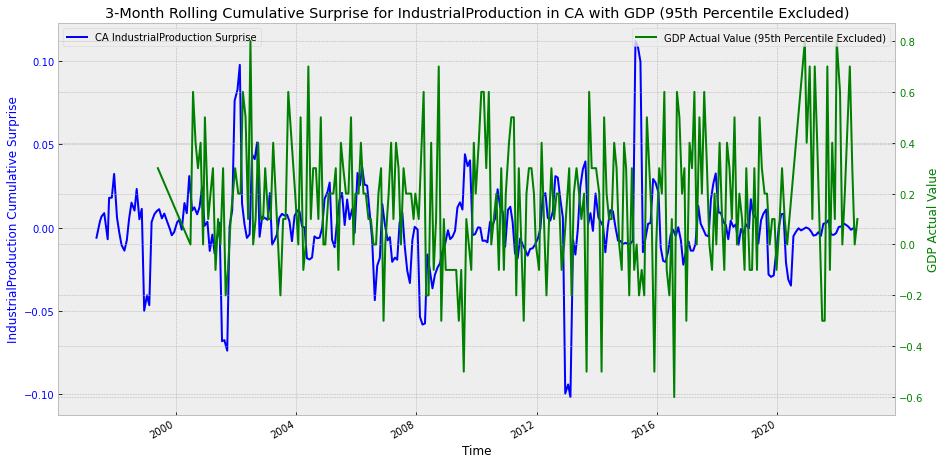

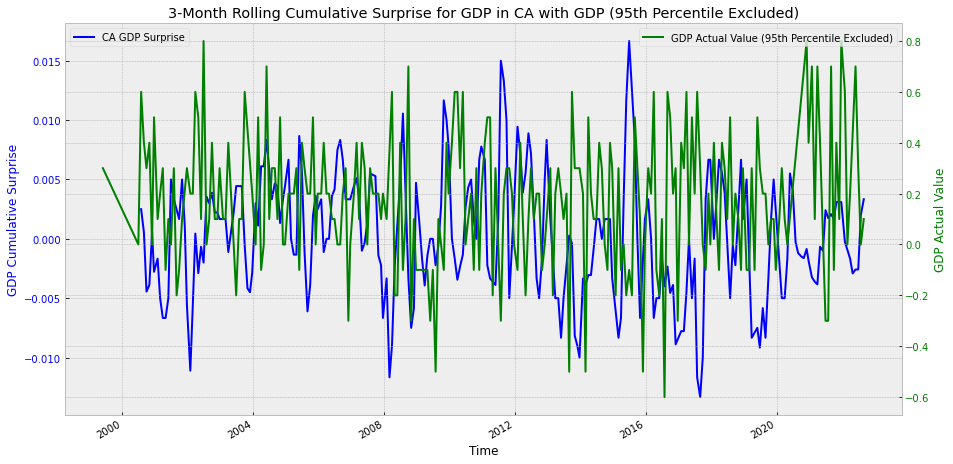

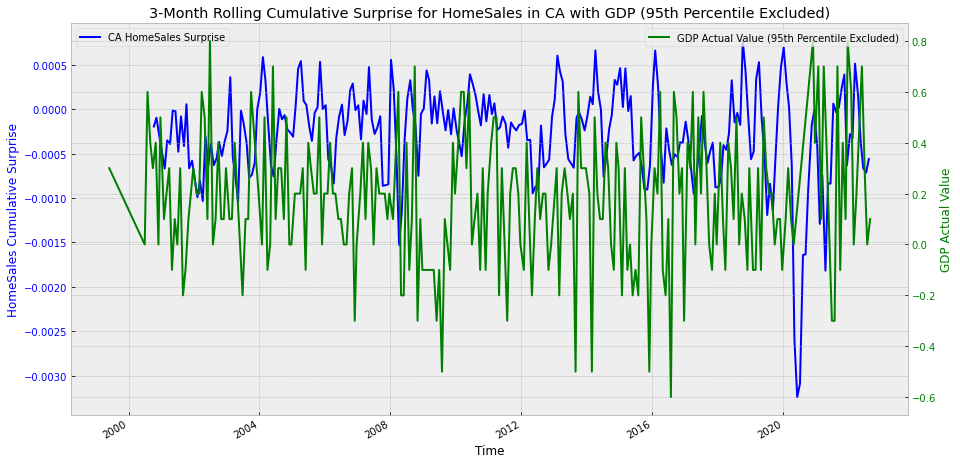

In [18]:

def plot_surprise_rolling(economic_data, region, parameter, window):
    df = economic_data[region][parameter]
    df = df[df['expected_value'] != 0]
    
    surprise = (df['expected_value'] - df['actual_value']) / df['expected_value']
    surprise = surprise.fillna(0).replace(np.inf, 0)    
    surprise /= 100

    cumulative_surprise = surprise.rolling(window=window).mean()    
    fig, ax1 = plt.subplots()

    cumulative_surprise.plot(ax=ax1, label=f"{region} {parameter} Surprise", color='blue')
    ax1.set_xlabel("Time")
    ax1.set_ylabel(f"{parameter} Cumulative Surprise", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    
    gdp_98th_percentile = economic_data[region]['GDP']["actual_value"].quantile(0.98)
    gdp_2nd_percentile = economic_data[region]['GDP']["actual_value"].quantile(0.02)

    filtered_gdp_actual = economic_data[region]['GDP']["actual_value"][np.logical_and(
        economic_data[region]['GDP']["actual_value"] < gdp_98th_percentile,
        economic_data[region]['GDP']["actual_value"] > gdp_2nd_percentile)]
    
    # Create the second axis for the GDP actual value, excluding values above the 95th percentile
    ax2 = ax1.twinx()  
    filtered_gdp_actual.plot(ax=ax2, color='green', label='GDP Actual Value (95th Percentile Excluded)')
    ax2.set_ylabel('GDP Actual Value', color='green')  
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    plt.title(f"{window}-Month Rolling Cumulative Surprise for {parameter} in {region} with GDP (95th Percentile Excluded)")
    plt.show()

for indicator in economic_data["US"]:
    plot_surprise_rolling(economic_data,country,indicator,3)



These all seemed to lead GDP for the countries, but only at various times. I now want to look at how this looks in aggregate. To do this, I will look at the 6 monthy rolling average. This will encorporate 2 quarters of economic indicators, and should give us a good idea of where GDP will trend towards. It should also make the trend more defined, and easy to interperet.

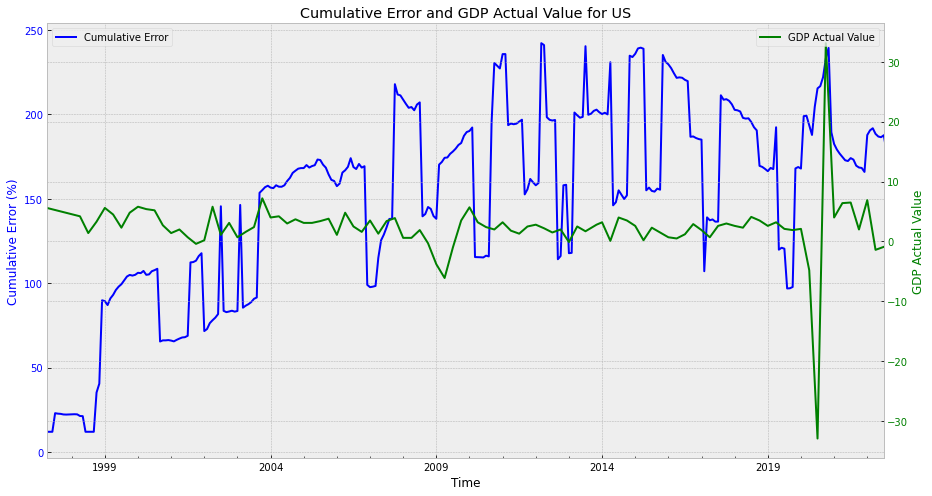

In [19]:
def plot_cumulative(dataframes):
    all_ts_frames = []
    for factor in dataframes:
        df = dataframes[factor].copy()  
        if "dates" in df.columns:
            df.set_index("dates", inplace=True)
        df_filtered = df[df['expected_value'] != 0].copy()  
        df_filtered.loc[:, "surprise"] = (df_filtered['expected_value'] - df_filtered['actual_value']) / df_filtered['expected_value']
        
        df_filtered.loc[:, "surprise"] =   df_filtered["surprise"]
        
        df_monthly = df_filtered.resample('M').mean() 
        df_rolling = df_monthly.rolling(window=6).mean()  
        df_rolling = df_rolling.fillna(0).replace(np.inf, 0).replace(-np.inf, 0) + 1
        
        all_ts_frames.append(df_rolling)
    
    # Concatenate all factors' frames
    dfs = pd.concat(all_ts_frames, axis=1)
    dfs["Sum"] = dfs.sum(axis=1)
    
    return dfs["Sum"]
fig, ax1 = plt.subplots()

# Assuming plot_cumulative returns a Series or DataFrame that can be plotted directly
# And also assuming plot_cumulative is adjusted to handle a region directly for simplification
cumulative_error = plot_cumulative(economic_data["US"])
cumulative_error.plot(ax=ax1, color='blue', label='Cumulative Error')

# Set labels and legend for the first axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Error (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()

# Plot the actual GDP values on the secondary axis
economic_data["US"]['GDP']["actual_value"].plot(ax=ax2, color='green', label='GDP Actual Value')

# Set labels and legend for the second axis
ax2.set_ylabel('GDP Actual Value', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Title of the figure
plt.title('Cumulative Error and GDP Actual Value for US')

plt.show()

The above shows a number of instances where the cumulative error, when the delta is large, it tends to lead a decline or gain in GDP. From here, I would like to assess the accuracy of my indicator by checking if the change in cumulative error is >5%, which I would consider to be a large swing "error" to occur across all 4 indicators.

In [20]:
def plot_cumulative_with_signal(dataframes):
    all_ts_frames = []
    for factor in dataframes:
        df = dataframes[factor].copy()
        if "dates" in df.columns:
            df.set_index("dates", inplace=True)
        df_filtered = df[df['expected_value'] != 0].copy()
        df_filtered["surprise"] = (df_filtered['expected_value'] - df_filtered['actual_value']) / df_filtered['expected_value']
        
        
        df_monthly = df_filtered.resample('M').mean()
        df_rolling = df_monthly.rolling(window=6).mean()
        df_rolling = df_rolling.fillna(0).replace(np.inf, 0).replace(-np.inf, 0) + 1
        
        all_ts_frames.append(df_rolling["surprise"])
    
    dfs = pd.concat(all_ts_frames, axis=1)
    dfs["Sum"] = dfs.sum(axis=1)

    dfs["signal"] = 0
    dfs["pct_change"] = dfs["Sum"].pct_change() * 100
    dfs.loc[dfs["pct_change"] >= 5, "signal"] = 1
    dfs.loc[dfs["pct_change"] <= -5, "signal"] = -1
    dfs["signal"] = dfs["signal"].replace(to_replace=0, method='ffill')

    first_non_zero = dfs["signal"].ne(0).idxmax()
    dfs.loc[:first_non_zero, "signal"] = dfs.loc[first_non_zero, "signal"]
    
    return dfs

def compare_signal_to_gdp_growth(dfs, gdp_for_region):
    gdp_for_region.index = pd.to_datetime(gdp_for_region.index)
    gdp_for_region = gdp_for_region.sort_index()
    gdp_for_region["next_period_growth_rate"] = gdp_for_region["actual_value"].pct_change(periods=-1) * -100
    combined = dfs.join(gdp_for_region[["next_period_growth_rate"]])
    
    dfs_with_signal['year_month'] = dfs.index.to_period('M')
    gdp_for_region['year_month'] = gdp_for_region.index.to_period('M')    
    score = 0
    total= 0
    dfs_with_signal['shifted_signal'] = dfs_with_signal['signal'].shift(-1)
    
    # Iterate through the GDP DataFrame
    for index, row in gdp_for_region.iterrows():
        current_ym = row['year_month']
        if current_ym in dfs_with_signal['year_month'].values:
            # Find the corresponding signal for the current month in dfs_with_signal
            signal_row = dfs_with_signal.loc[dfs_with_signal['year_month'] == current_ym]
            if not signal_row.empty:
                # Assuming positive signal predicts growth, and negative signal predicts decline
                signal = signal_row['shifted_signal'].iloc[0]  # Get the first (should be only) signal value
                MoM_growth = row['actual_value']

                # Scoring logic
                if pd.notnull(MoM_growth):
                    if (signal == 1 and MoM_growth > 0) or (signal == -1 and MoM_growth < 0):
                        score += 1  # Correct prediction
        total+=1

    return str((score/total)*100)+"%"


dfs_with_signal = plot_cumulative_with_signal(economic_data['US'])
gdp_growth_df = economic_data["US"]["GDP"]  # Assuming this DataFrame contains the actual GDP growth data
score = compare_signal_to_gdp_growth(dfs_with_signal, gdp_growth_df)
print("USA Score:", score)
dfs_with_signal = plot_cumulative_with_signal(economic_data['CA'])
gdp_growth_df = economic_data["CA"]["GDP"]  # Assuming this DataFrame contains the actual GDP growth data
score = compare_signal_to_gdp_growth(dfs_with_signal, gdp_growth_df)
print("Canada Score:", score)


USA Score: 58.58585858585859%
Canada Score: 47.01492537313433%


Overall I am happy with this indicator. Over the entire dataset, it accurately predicted GDP growth 58.6% of the time for the US and 47% of the time for Canda, meaning that it has some merits as an economic indicator, with an average accuracy of 52.8%




# Trading Indicator

Now to try and translate this into a trading signal. As GDP data is released monthly, and markets are constantly swinging and reacting to much more granular events, I will halve the window time and instead of summing, multiply the indicators so that they can cancel each other out or amplify each other in this shorter timeframe. 

In [21]:
import pandas as pd
import numpy as np

def signal(dataframes):
    all_ts_frames = []
    for factor in dataframes:
        print(factor)
        df = dataframes[factor].copy()  
        if "dates" in df.columns:
            df.set_index("dates", inplace=True)
        df_filtered = df[df['expected_value'] != 0].copy()  
        df_filtered.loc[:, "surprise"] = (df_filtered['expected_value'] - df_filtered['actual_value']) / df_filtered['expected_value']
        
        
        df_monthly = df_filtered.resample('M').mean() 
        df_rolling = df_monthly.rolling(window=3).mean()  
        df_rolling = df_rolling.fillna(0).replace(np.inf, 0).replace(-np.inf, 0) + 1
        
        all_ts_frames.append(df_rolling)
    
    # Concatenate all factors' frames
    dfs = pd.concat(all_ts_frames, axis=1)
    
    # Initialize all signals to -1, then update based on Product condition
    dfs["Product"] = dfs.product(axis=1)
    dfs["Signal"] = -1
    dfs.loc[dfs["Product"] > 1, 'Signal'] = 1
    
    return dfs["Signal"]



In [22]:
#Setting Signal
ca_sgnl = signal(economic_data["CA"])#['IndustrialProduction'])
us_sgnl = signal(economic_data["US"])


#Only including equities as the signal only takes a country's own economic data into consideration. 
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()
ca_daily_pos = ca_sgnl.resample('D').ffill()
us_daily_pos = us_sgnl.resample('D').ffill()

ca_pnl2 = calculate_pnl(ca_returns,  us_daily_pos)

us_pnl2 = calculate_pnl(us_returns,  us_daily_pos)



Unemployment
IndustrialProduction
GDP
HomeSales
Unemployment
IndustrialProduction
GDP
HomeSales


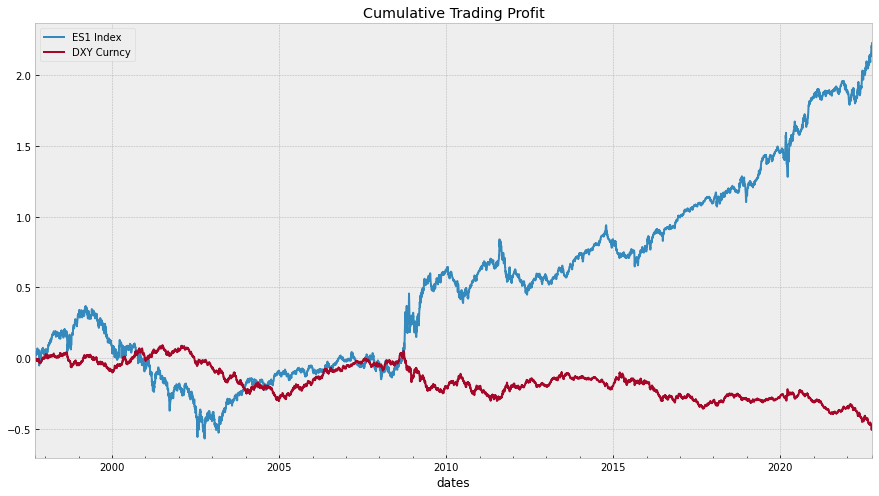

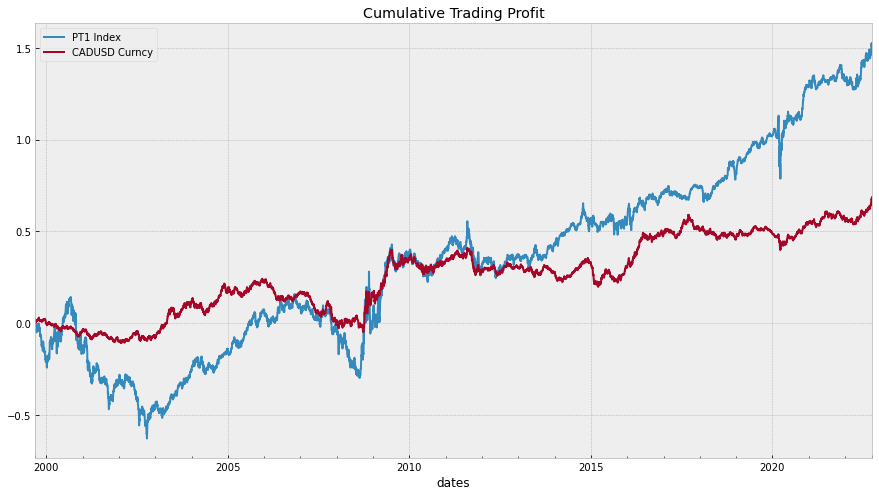

In [23]:
us_pnl2.cumsum().plot(title='Cumulative Trading Profit')

ca_pnl2.cumsum().plot(title='Cumulative Trading Profit')
plt.show()

I would not use this indicator for trading USDCAD or CADUSD, as it does not incorporate the other country's economic strength.

# Conclusion
Overall, I feel that this indicator markes sense. As I worked through this excercise, I gradually refined my indicator into relatively accurate economic and stock indicators.

I started by looking to the divergences from expectations, as when things are relatively constant, growth is predictable. There is a momemtum factor to both GDP growth and equity markets, so when there is a hard switch in either of the markets (with different timelines), it is indicative that the direction of the asset will continue in that direction. 

Reducing the window size in equity markets makes sense, as 

In [24]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.
